# Importamos librerias y conjunto de datos

In [322]:
# para manipular datos
import pandas as pd
import numpy as np

# para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# para la transformada de yeo-Johnson
import scipy.stats as stats

# para dividir en conjuntos de entrenamiento y test
from sklearn.model_selection import train_test_split

# para escalar variables
from sklearn.preprocessing import MinMaxScaler

# para salvar las escalas
import joblib

# para visualizar todas las columnas del dataset
pd.pandas.set_option('display.max_columns', None)

In [269]:
# carga del dataset
data = pd.read_csv('../Telco-Customer-Churn.csv')

# vemos la cantidad de filas y columnas
print(data.shape)

# visualizamos el encabezado del dataset
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Vemos como a TotalCharges la identifica como object, SeniorCitizen como numerica y Churn como Object. Antes de continuar, las reconvertimos a float64 y category respectivamente

In [271]:
# cambiamos TotalCharges

data["TotalCharges"]=pd.to_numeric(data["TotalCharges"],errors="coerce")

# Cambiamos SeniorCitizen
data["SeniorCitizen"] = data["SeniorCitizen"].astype('category')

# Cambiamos SeniorCitizen
data["Churn"] = data["Churn"].astype('category')

In [272]:
ls_var = data.columns
ls_var=ls_var.drop(["customerID","Churn"])
ls_var=list(ls_var)

# Ingenieria de variables

En las siguientes celdas, diseñaremos las variables del conjunto de datos de para abordar:

1. Valores faltantes
2. Variables temporales
3. Distribucion de variables no gaussianas
4. Variables categoricas: borrar etiquetas raras
5. variables categoricas: Convertir a numeros las cadena de texto
5. Transformar las variables a escalas similares

## Target

La transformamos a formato de 0, 1

In [277]:
def verifica(val):
    if val=="No":
        return 0
    elif val=="Yes":
        return 1
        
data["Churn"]=data["Churn"].map(verifica)

print(data["Churn"].value_counts())


0    5174
1    1869
Name: Churn, dtype: int64


## Valores faltantes

### Categorical variables

Reemplazaremos los valores perdidos con la cadena "faltante" en aquellas variables con muchos datos faltantes. 

Alternativamente, reemplazaremos los datos faltantes con la categoría más frecuente en aquellas variables que contienen menos observaciones sin valores. 

Esta es una práctica común.

In [278]:
# identifiquemos las variables categóricas 
# capturaremos las de tipo objeto y las cambiamos a category

cat_vars = [var for var in ls_var if data[var].dtype == 'O']


# Reconvertimos todas las variables categoricas
data[cat_vars] = data[cat_vars].astype('category')


# número de variables categóricas
cat_vars

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [279]:
# hacemos una lista de las variables categóricas que contienen valores faltantes

cat_vars_with_na = [
    var for var in cat_vars
    if data[var].isnull().sum() > 0
]

# vemos el porcentaje de valores perdidos por variable
data[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

In [280]:
# variables para imputar con la cadena que falta
with_string_missing = [
    var for var in cat_vars_with_na if data[var].isnull().mean() > 0.1]

# variables a imputar con la categoría más frecuente
with_frequent_category = [
    var for var in cat_vars_with_na if data[var].isnull().mean() < 0.1]

In [281]:
with_frequent_category

[]

In [282]:
with_string_missing

[]

### Variables Numericas

Para diseñar valores perdidos en variables numéricas, haremos lo siguiente:

- Agregar una variable indicadora binaria que falta 
- y luego Reemplace los valores faltantes en la variable original con la media

In [286]:
# identifiquemos las variables numéricas

num_vars = [
    var for var in data.columns if var not in cat_vars and var != 'Churn'
]

# número de variables numéricas

num_vars


['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [285]:
# hacer una lista con las variables numéricas que contienen valores perdidos
vars_with_na = [
    var for var in num_vars
    if data[var].isnull().sum() > 0
]

# porcentaje de valores perdidos por variable
data[vars_with_na].isnull().mean()

TotalCharges    0.001562
dtype: float64

In [287]:
# Reemplazamos los valores faltantes cencontrados anteriormente

for var in vars_with_na:

    # calcular la media usando el conjunto
    mean_val = data[var].mean()
    
    print(var, mean_val)

    # agregamos indicador binario de faltante (en train y test)
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    # Reemplazar los valores faltantes por la media 
    data[var].fillna(mean_val, inplace=True)

# Verificamos que no tenemos más valores faltantes en las variables diseñadas
data[vars_with_na].isnull().sum()

TotalCharges 2283.3004408418697


TotalCharges    0
dtype: int64

In [288]:
# Verificamos que el conjunto de prueba no contenga valores nulos en las variables diseñadas

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [289]:
# comprobamos las variables indicadoras binarias que faltan

X_train["SeniorCitizen"].head()

2499    0
5807    0
5118    0
275     0
1350    0
Name: SeniorCitizen, dtype: category
Categories (2, int64): [0, 1]

## Variables Categoricas


In [290]:
# Desplegamos para visualizar las distintas categoria de cada variable

for var in cat_vars:
    print (data.groupby(var)[var].count())
    print("------------------------------")

gender
Female    3488
Male      3555
Name: gender, dtype: int64
------------------------------
Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
------------------------------
Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
------------------------------
PhoneService
No      682
Yes    6361
Name: PhoneService, dtype: int64
------------------------------
MultipleLines
No                  3390
No phone service     682
Yes                 2971
Name: MultipleLines, dtype: int64
------------------------------
InternetService
DSL            2421
Fiber optic    3096
No             1526
Name: InternetService, dtype: int64
------------------------------
OnlineSecurity
No                     3498
No internet service    1526
Yes                    2019
Name: OnlineSecurity, dtype: int64
------------------------------
OnlineBackup
No                     3088
No internet service    1526
Yes                    2429
Name: OnlineBackup, dtype: int64
------------------------

### Transformacion de Categorias

Identificamos cada categoria tipo cadena y le asignamos un numero. Luego Convertimos

In [291]:
# PaymentMethod

PaymentMethod={
    "Bank transfer (automatic)":0,
    "Credit card (automatic)":1,
    "Electronic check":2,
    "Mailed check":3
}

data["PaymentMethod"]= data["PaymentMethod"].map(PaymentMethod)


In [292]:
# Contract

contract={
    "Month-to-month":0,
    "One year":1,
    "Two year":2
}

data["Contract"]= data["Contract"].map(contract)


In [293]:
# Yes_No

y_n={
    "No":0,
    "Yes":1,
    "Female":0,
    "Male":1
}

vars_y_n=["gender","Partner","Dependents","PhoneService","PaperlessBilling"]

for var in vars_y_n:
    data[var]= data[var].map(y_n)


In [294]:
# Yes_No_No internet service

y_n_nis={
    "No":0,
    "Yes":1,
    "No internet service":2
}

var_y_n_nis=["OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","OnlineSecurity"]

for var in var_y_n_nis:
    data[var]= data[var].map(y_n_nis)


In [295]:
# Yes_No_No phone service

y_n_np={
    "No":0,
    "Yes":1,
    "No phone service":2
}


data["MultipleLines"]= data["MultipleLines"].map(y_n_np)


In [296]:
# DSL Fiber optic No

InternetService={
    "No":0,
    "DSL":1,
    "Fiber optic":2
}
data["InternetService"]= data["InternetService"].map(InternetService)


In [297]:
data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_na
0,7590-VHVEG,0,0,1,0,1,0,2,1,0,1,0,0,0,0,0,1,2,29.85,29.85,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,3,56.95,1889.50,0,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,3,53.85,108.15,1,0
3,7795-CFOCW,1,0,0,0,45,0,2,1,1,0,1,1,0,0,1,0,0,42.30,1840.75,0,0
4,9237-HQITU,0,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,2,70.70,151.65,1,0
5,9305-CDSKC,0,0,0,0,8,1,1,2,0,0,1,0,1,1,0,1,2,99.65,820.50,1,0
6,1452-KIOVK,1,0,0,1,22,1,1,2,0,1,0,0,1,0,0,1,1,89.10,1949.40,0,0
7,6713-OKOMC,0,0,0,0,10,0,2,1,1,0,0,0,0,0,0,0,3,29.75,301.90,0,0
8,7892-POOKP,0,0,1,0,28,1,1,2,0,0,1,1,1,1,0,1,2,104.80,3046.05,1,0
9,6388-TABGU,1,0,0,1,62,1,0,1,1,1,0,0,0,0,1,0,0,56.15,3487.95,0,0


# Discretizaciones

La discretizacion nos permitira segmentar variables continuas a fin de aumentar el poder explicativo y predictivo

## tenure y TotalCharges

In [299]:
# Funcion para discretizar

def discretizar(df,var,ls_cortes):
    df=df.copy()
    df[var]=pd.qcut(df[var],ls_cortes)
    df[var]=df[var].astype("category")
    return df[var]

In [300]:
# Los cortes son los quantiles
ls_cortes=[0,0.25,0.5,0.75,1]

# Tenure
data["tenure_disc"]=discretizar(data,"tenure",ls_cortes)

In [301]:
# TotalCharges
data["TotalCharges_disc"]=discretizar(data,"TotalCharges",ls_cortes)

In [302]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_na,tenure_disc,TotalCharges_disc
0,7590-VHVEG,0,0,1,0,1,0,2,1,0,1,0,0,0,0,0,1,2,29.85,29.85,0,0,"(-0.001, 9.0]","(18.799, 402.225]"
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,3,56.95,1889.50,0,0,"(29.0, 55.0]","(1400.55, 3786.6]"
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,3,53.85,108.15,1,0,"(-0.001, 9.0]","(18.799, 402.225]"
3,7795-CFOCW,1,0,0,0,45,0,2,1,1,0,1,1,0,0,1,0,0,42.30,1840.75,0,0,"(29.0, 55.0]","(1400.55, 3786.6]"
4,9237-HQITU,0,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,2,70.70,151.65,1,0,"(-0.001, 9.0]","(18.799, 402.225]"


# Borramos variables sin uso

In [303]:
# Vamos a prescindir de estas variables

variables_a_borrar = ["customerID","tenure","MonthlyCharges","TotalCharges","TotalCharges_na"]

In [306]:
# Borramos las variables que no vamos a usar

data.drop(columns=variables_a_borrar,inplace=True)


# Verificacion de tipos

Reconvertimos a numerica la variable target para poder graficar

In [324]:
data["churn"]=data["Churn"].astype("int64")

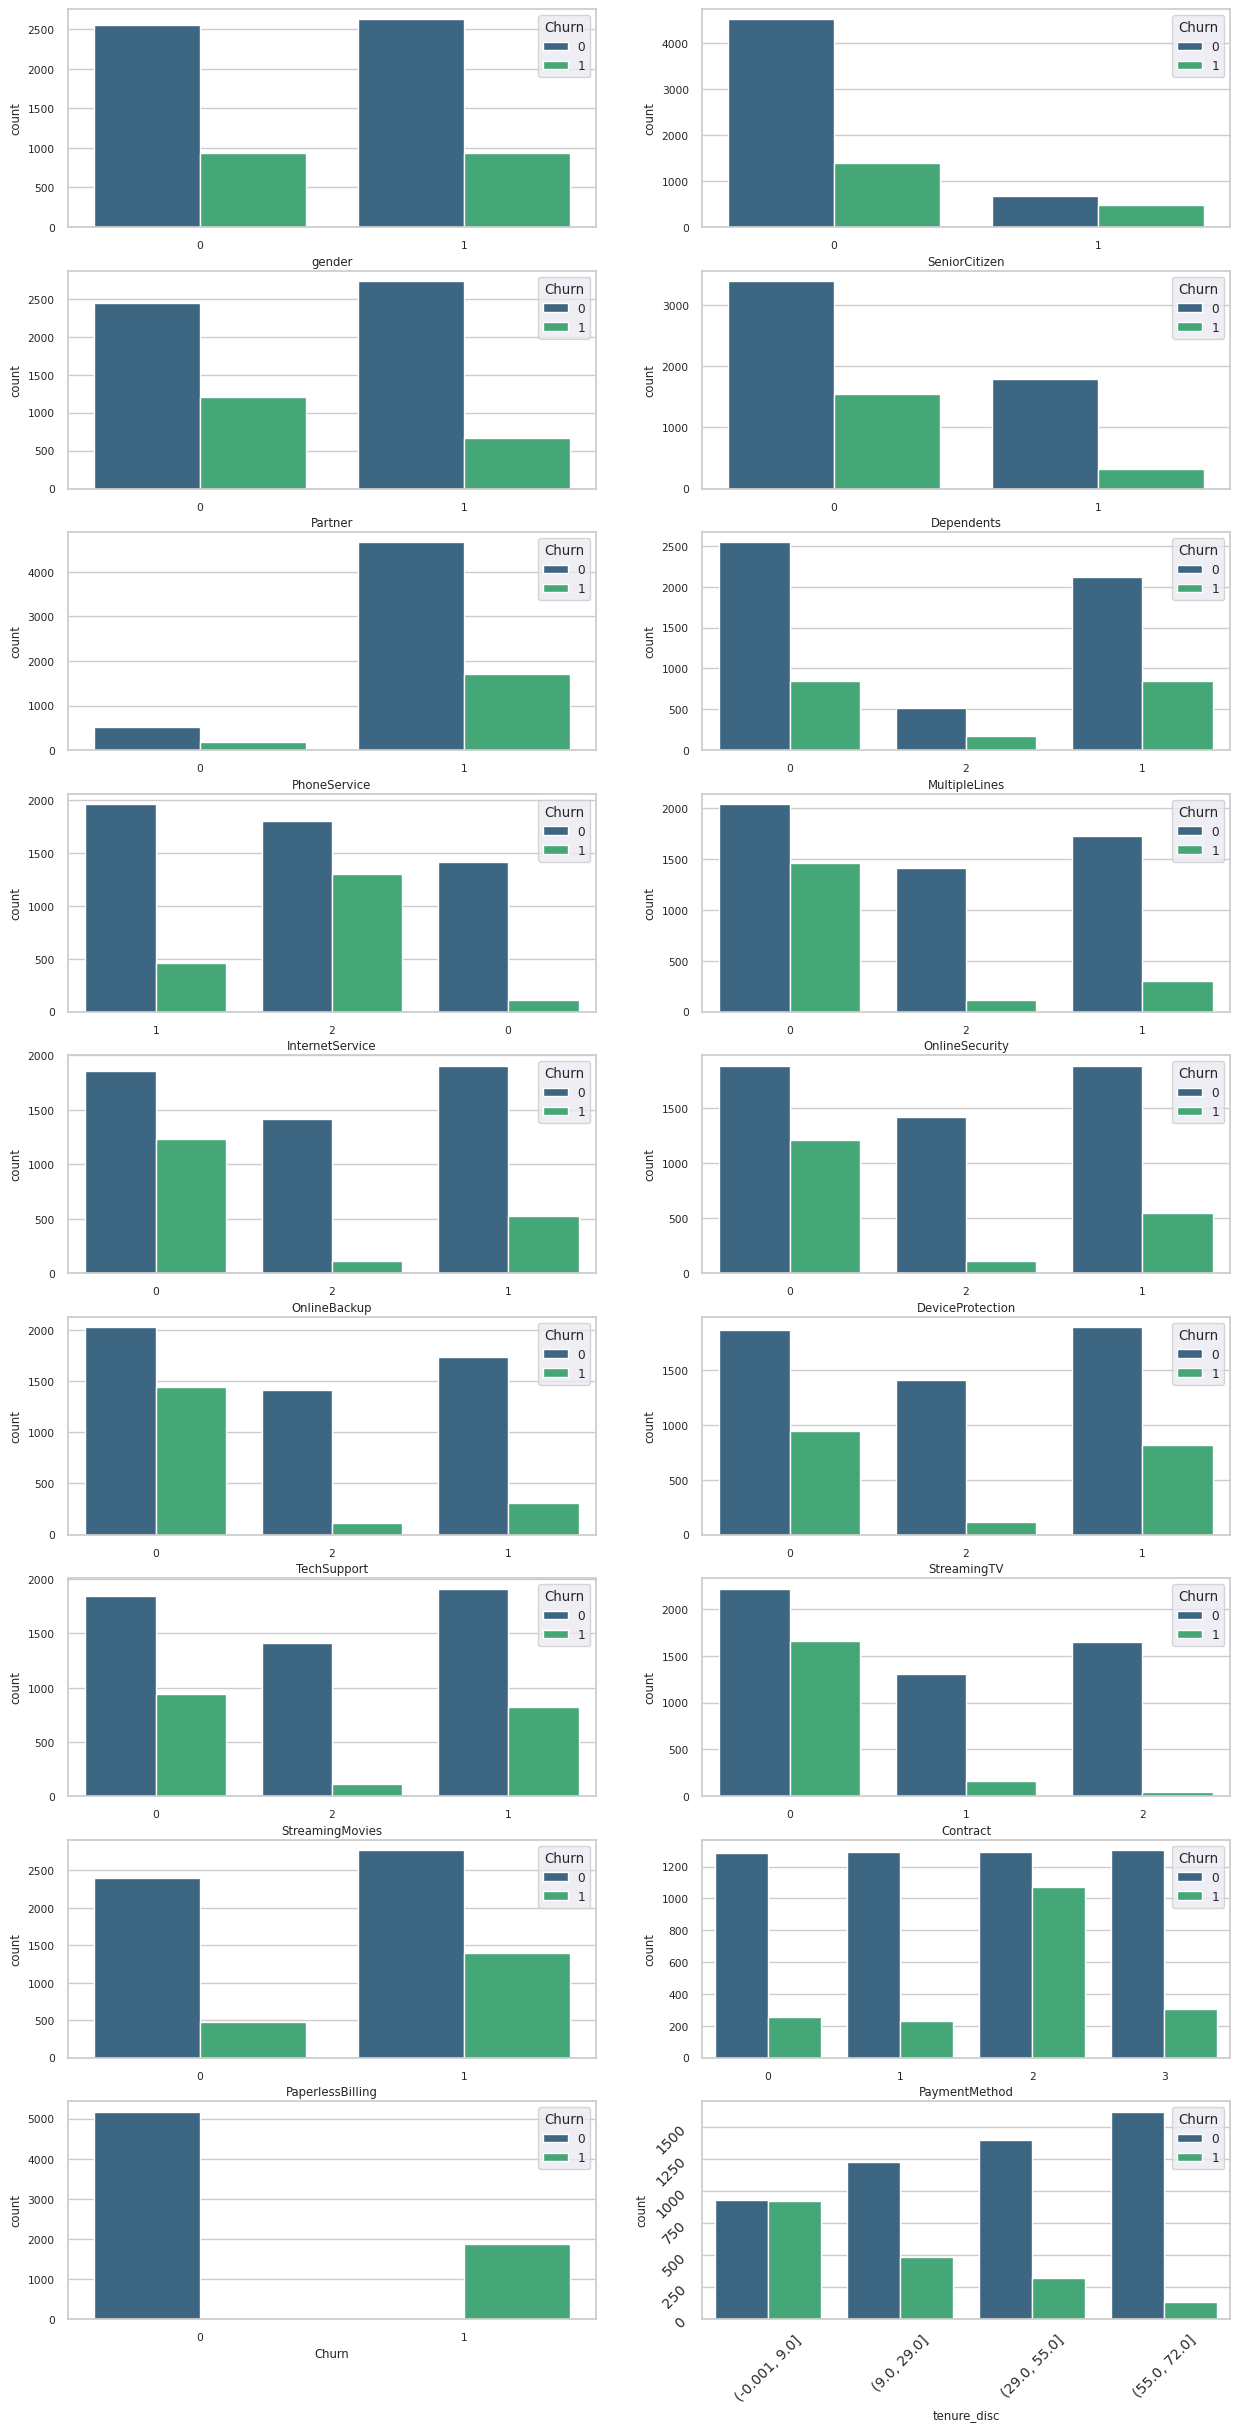

In [327]:

sns.reset_defaults()
sns.set(font_scale=0.7, style="whitegrid")

ls_cat=list(data.columns)

n_rows=9
n_cols=2

f, ax=plt.subplots(nrows=n_rows,
                   ncols=n_cols,
                   figsize = (15,30))

i=0

for row in range(0,n_rows,1):
    sns.set(font_scale=0.8)
    plt.tick_params(labelsize=10, labelrotation=45)
    
    for col in range(0,n_cols,1):
        sns.countplot(ax=ax[row,col],data=data, x=ls_cat[i],hue="Churn",palette="viridis")
        i+=1

sns.reset_defaults()

# Separamos en conjunto de train y test

In [328]:
# Separemos en entramiento y conjunto de prueba 

target=data["Churn"]


X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Churn', axis=1), # variables predictivas
    target, # target
    test_size=0.2, # porción del conjunto de datos para asignar al conjunto de prueba
    random_state=0, # estamos poniendo la semilla aquí
    stratify=target # para que la generacion de las clases este compensada
)

X_train.shape, X_test.shape

((5634, 19), (1409, 19))

In [329]:
# comprobar la ausencia de na en el train
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [330]:
# comprobar la ausencia de na en el test
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

## Guardamos los Conjuntos de Prueba y entrenamiento


In [334]:
# Guardemos ahora el train y los conjuntos de prueba

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)